# Embeddings
- [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_annoy.html?highlight=load%20word2vec%20txt#work-with-google-s-word2vec-files) - **why do I need it????**
- [tokenizer](https://github.com/google/sentencepiece/blob/master/python/README.md)


## Load data (separate dataset)
- the 2008-2016 dataset 
- python language

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks 
from tensorflow.keras import optimizers

In [2]:
df = pd.read_csv("py_df.csv")

In [3]:
df = df.drop(columns=["round", "task", "solution", "file", "full_path", "Unnamed: 0.1", "Unnamed: 0", "lang"])

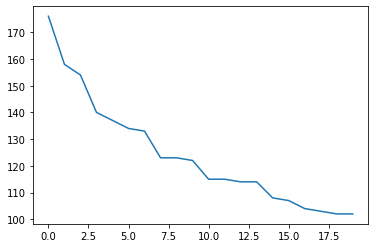

In [4]:
# let's collect 20 users with avg amount of files, which is around 100
# (enough files, but their difference amount is not sufficient)

plt.plot(np.array(df.username.value_counts())[:20])

In [5]:
users = df.username.value_counts()[:20].index
data_for_users = df[df.username.isin(users)]

In [6]:
data_for_users.head()

,year,username,flines
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \..."
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")..."
7,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")..."
8,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""b.in"", ""r"")..."
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...


In [7]:
# let's find avg file length (in chars)
data_for_users.flines.apply(lambda x: len(str(x))).describe()

count     2484.000000
mean      1890.791063
std       2082.923724
min        129.000000
25%        750.000000
50%       1326.000000
75%       2206.250000
max      38876.000000
Name: flines, dtype: float64

In [8]:
# let's find avg file length (in lines)
data_for_users["n_lines"] = data_for_users.flines.apply(lambda x: str(x).count("\n"))
data_for_users["n_lines"].describe()

/Users/alinabogdanova/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    2484.000000
mean       69.780998
std        60.443797
min         0.000000
25%        32.000000
50%        54.000000
75%        87.000000
max       615.000000
Name: n_lines, dtype: float64

In [9]:
# remove files with amount of lines not in [30, 100] -> decrease on 1/2
data_for_users = data_for_users[(data_for_users.n_lines>=30)&(data_for_users.n_lines<=100)]

In [10]:
data_for_users.n_lines.describe()

count    1444.000000
mean       58.090720
std        18.921421
min        30.000000
25%        41.000000
50%        56.000000
75%        72.000000
max       100.000000
Name: n_lines, dtype: float64

In [11]:
# remove authors with small amount of files
data_for_users.username.value_counts().describe()

count     20.000000
mean      72.200000
std       26.804556
min       26.000000
25%       62.500000
50%       66.500000
75%       86.000000
max      135.000000
Name: username, dtype: float64

In [12]:
tobe_saved = data_for_users.username.value_counts()[:75].index

In [13]:
data_for_users = data_for_users[data_for_users.username.isin(tobe_saved)]

In [14]:
data_for_users

,year,username,flines,n_lines
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48
23,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85
28,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38
...,...,...,...,...
153468,2016,graygrass,import os\n import itertools\n \n class Solver...,81
155179,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,78
155180,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35
155181,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35


In [15]:
# let's find avg file length (in chars)
data_for_users["n_chars"] = data_for_users.flines.apply(lambda x: len(str(x)))

In [16]:
(data_for_users.n_chars/data_for_users.n_lines).describe()

count    1444.000000
mean       25.140966
std         5.511347
min        13.890625
25%        22.025952
50%        24.444444
75%        27.255102
max       101.256410
dtype: float64

In [17]:
# suspicious max value let's drop evetyrhing, highter then 102 and look, what's left
data_for_users["chars_per_line"] = data_for_users.n_chars/data_for_users.n_lines

In [18]:
data_for_users = data_for_users[data_for_users.chars_per_line<102]

In [19]:
# only two files were rmoved
data_for_users

,year,username,flines,n_lines,n_chars,chars_per_line
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512
6,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000
21,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833
23,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353
28,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474
...,...,...,...,...,...,...
153468,2016,graygrass,import os\n import itertools\n \n class Solver...,81,2329,28.753086
155179,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,78,1763,22.602564
155180,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35,723,20.657143
155181,2016,Nooodles,### Google code jam 2016\n ### Online round 1C...,35,723,20.657143


In [20]:
data_for_users.describe()

,year,n_lines,n_chars,chars_per_line
count,1444.000000,1444.000000,1444.000000,1444.000000
mean,2012.259003,58.090720,1466.790166,25.140966
std,2.420336,18.921421,586.463777,5.511347
min,2008.000000,30.000000,508.000000,13.890625
25%,2010.000000,41.000000,1029.500000,22.025952
50%,2012.000000,56.000000,1377.000000,24.444444
75%,2014.000000,72.000000,1797.750000,27.255102
max,2016.000000,100.000000,3970.000000,101.256410


In [21]:
# let's leave the dataset, as it is for now
df = data_for_users

## Embedding

In [23]:
sp = spm.SentencePieceProcessor(model_file='embd/sentencepiece_bpe.model')
sp.encode('\tarr = [int(x) for x in str.split()]')

[6682, 14, 127, 184, 96091, 96097, 96090, 115, 419, 57, 420, 96084, 1300, 5382]

In [24]:
print(sp.decode(sp.encode('    arr = [int(x) for x in str.split()]')))

arr = [int(x) for x in str.split()]


In [25]:
# we loose layout features!

In [26]:
df.index = np.arange(len(df))

In [27]:
df["n_tokens"] = df.flines.apply(lambda x: len(sp.encode(x)))

In [28]:
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000
mean,2012.259003,58.090720,1466.790166,25.140966,374.316482
std,2.420336,18.921421,586.463777,5.511347,145.009738
min,2008.000000,30.000000,508.000000,13.890625,134.000000
25%,2010.000000,41.000000,1029.500000,22.025952,267.000000
50%,2012.000000,56.000000,1377.000000,24.444444,343.000000
75%,2014.000000,72.000000,1797.750000,27.255102,469.000000
max,2016.000000,100.000000,3970.000000,101.256410,1323.000000


In [29]:
# rm files with amount of tokens less greater, then 500
df = df[df.n_tokens<=500]

In [30]:
df.describe()

,year,n_lines,n_chars,chars_per_line,n_tokens
count,1180.000000,1180.000000,1180.000000,1180.000000,1180.000000
mean,2012.228814,52.707627,1271.999153,24.280568,322.824576
std,2.410083,15.675411,403.300208,4.194308,89.515446
min,2008.000000,30.000000,508.000000,13.890625,134.000000
25%,2010.000000,40.000000,954.250000,21.634412,252.000000
50%,2012.000000,51.000000,1256.000000,23.675676,321.000000
75%,2014.000000,61.250000,1543.000000,26.495614,388.000000
max,2016.000000,99.000000,2966.000000,43.633333,500.000000


In [31]:
# let's hope, that min = 21 is ok
df.username.value_counts()

EricStansifer    124
lidaobing         98
RalfKistner       84
gizzywump         75
kmod              71
mth               66
Martial           64
Sp3000            63
raja.baz          58
Fizu              58
linguo            57
zibada            55
zli               52
Nooodles          51
graygrass         46
eMBe              42
tanriol           34
bigOnion          32
kusano            29
festony           21
Name: username, dtype: int64

In [32]:
df["tokens"] = df.flines.apply(lambda x: sp.encode(x))

/Users/alinabogdanova/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df.head()

,year,username,flines,n_lines,n_chars,chars_per_line,n_tokens,tokens
0,2008,mth,"#!/usr/bin/env python\n \n def comb(a, b):\n \...",41,870,21.219512,297,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
1,2008,RalfKistner,"#!/usr/bin/python\n \n fin = open(""d.in"", ""r"")...",50,1040,20.800000,335,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
2,2008,lidaobing,import sys\n \n def getints(ifile):\n retu...,48,931,19.395833,250,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
3,2008,lidaobing,import sys\n import psyco\n psyco.full()\n imp...,85,1911,22.482353,480,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
4,2008,gizzywump,#!/usr/bin/env python\n \n import sys\n \n CAC...,38,885,23.289474,285,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."


In [34]:
dataset = df[["username", "tokens"]]

In [35]:
dataset

,username,tokens
0,mth,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 6..."
1,RalfKistner,"[3238, 2785, 96124, 1119, 96124, 1796, 3014, 1..."
2,lidaobing,"[138, 1149, 63, 398, 7686, 96091, 96073, 252, ..."
3,lidaobing,"[138, 1149, 138, 20653, 62, 20653, 62, 96084, ..."
4,gizzywump,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
...,...,...
1437,RalfKistner,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 9..."
1440,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
1441,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."
1442,Nooodles,"[5059, 9337, 1174, 1250, 144, 9647, 5059, 4474..."


## Load data
Lib selected - tensorflow + keras

### Some small notes for future
Tensorflow supports python 3.8 as max version. The issue arises on latest Ubuntu/max os-es, when the default python version is 3.9.

What was done on MAC-OS-Big-Sur to solve that issue.
- [pyenv](https://github.com/pyenv/pyenv) installed
```bash
>> brew update
>> brew install pyenv
...
```
- python 3.7 installation
```
>> brew install python@3.7
```
- pyenv added python 3.7
```
>> pyenv install 3.7.10
>> pyenv loacal 3.7.10
```
- create [myenv](https://www.tensorflow.org/install/pip#2.-create-a-virtual-environment-recommended)
```
>> python3.7 -m venv myenv
>> source myenv/bin/activate.fish
```
- solution of the final problem - **UPGRADE PIP**
- install tensorflow
```
(myenv)>> pip install --upgrade tensorflow
```

In [37]:
le = LabelEncoder()
dataset.username = le.fit_transform(dataset.username)

/Users/alinabogdanova/Documents/workspace/research/myenv/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
# shuffle dataset
dataset = dataset.sample(frac = 1) 
dataset

,username,tokens
963,13,"[138, 1149, 1149, 96084, 123, 61427, 14, 54391..."
1220,13,"[138, 1149, 28, 14, 49585, 871, 96111, 250, 80..."
977,6,"[1678, 14, 24, 96113, 15003, 4398, 96124, 13, ..."
1179,0,"[138, 1149, 20094, 14, 159, 9379, 14, 159, 63,..."
158,2,"[35, 14, 24, 40161, 120, 1174, 1250, 144, 9608..."
...,...,...
390,15,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
349,2,"[138, 1149, 63, 921, 96077, 1123, 586, 121, 97..."
460,5,"[63, 4525, 96091, 96075, 45, 481, 96095, 14, 4..."
85,19,"[156, 13670, 1843, 138, 250, 63, 50846, 96091,..."


In [39]:
def rsh(x):
    arr = np.array(x)
    arr.resize(500)
    return list(arr)

dataset.tokens = dataset.tokens.apply(rsh)

In [40]:
dataset

,username,tokens
963,13,"[138, 1149, 1149, 96084, 123, 61427, 14, 54391..."
1220,13,"[138, 1149, 28, 14, 49585, 871, 96111, 250, 80..."
977,6,"[1678, 14, 24, 96113, 15003, 4398, 96124, 13, ..."
1179,0,"[138, 1149, 20094, 14, 159, 9379, 14, 159, 63,..."
158,2,"[35, 14, 24, 40161, 120, 1174, 1250, 144, 9608..."
...,...,...
390,15,"[3238, 2785, 96124, 1119, 96124, 1376, 1804, 1..."
349,2,"[138, 1149, 63, 921, 96077, 1123, 586, 121, 97..."
460,5,"[63, 4525, 96091, 96075, 45, 481, 96095, 14, 4..."
85,19,"[156, 13670, 1843, 138, 250, 63, 50846, 96091,..."


In [41]:
X = dataset.tokens.values
X = np.array(list(X))
X.shape

In [45]:
X = X.reshape((-1, 500))
y = np.array(dataset.username)

ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1, 1))
y = y.toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

### Structure of the model
1. CNN:
- ks = 50 (function - level)
- ks = 10 (line2 - level)
- ks = 5 (lene - level)
2. Linear ReLU 
3. softmax 75

> important note `tanh` activation increases accuracy from 11% to 60% ontraining (50% of test accuracy)
>
> `linear` function reaches up to 61% of test accuracy

In [53]:
model = keras.Sequential()
model.add(keras.Input(shape=(500)))  # 250x250 RGB images
# model.add(layers.Conv1D(100, 100, activation="relu"))
# model.add(layers.Conv1D(16, 5, activation="relu"))
# model.add(layers.MaxPooling1D(pool_size=4))
# model.add(layers.Flatten())
model.add(layers.Dense(256, activation="linear"))
# model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="linear"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation="softmax"))
# Can you guess what the current output shape is at this point? Probably not.
# Let's just print it:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               128256    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 163,732
Trainable params: 163,732
Non-trainable params: 0
_________________________________________________________________


In [55]:
optimizer = optimizers.Adam(0.1)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_delta=0.00001, verbouse=1)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [56]:
epochs = 100
batch_size = 20
history = model.fit(x=X_train, y=y_train, epochs = epochs, 
                    validation_data = (X_test,y_test),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=2, 
                    callbacks=[lr_schedule])

Epoch 1/100
44/44 - 2s - loss: 102738512.0000 - accuracy: 0.1115 - val_loss: 127947224.0000 - val_accuracy: 0.1797
Epoch 2/100
44/44 - 0s - loss: 269001408.0000 - accuracy: 0.1932 - val_loss: 322875392.0000 - val_accuracy: 0.2102
Epoch 3/100
44/44 - 0s - loss: 579322496.0000 - accuracy: 0.2572 - val_loss: 519131040.0000 - val_accuracy: 0.3559
Epoch 4/100
44/44 - 0s - loss: 850423808.0000 - accuracy: 0.3377 - val_loss: 877670400.0000 - val_accuracy: 0.3559
Epoch 5/100
44/44 - 0s - loss: 1099858304.0000 - accuracy: 0.3951 - val_loss: 1248106240.0000 - val_accuracy: 0.3864
Epoch 6/100
44/44 - 0s - loss: 1286957184.0000 - accuracy: 0.4360 - val_loss: 1406989952.0000 - val_accuracy: 0.4678
Epoch 7/100
44/44 - 0s - loss: 1434574464.0000 - accuracy: 0.4503 - val_loss: 1889645952.0000 - val_accuracy: 0.4712
Epoch 8/100
44/44 - 0s - loss: 1524684800.0000 - accuracy: 0.5331 - val_loss: 2464700672.0000 - val_accuracy: 0.4678
Epoch 9/100
44/44 - 0s - loss: 1471533056.0000 - accuracy: 0.5629 - val_

In [57]:
model.save('model.h5')

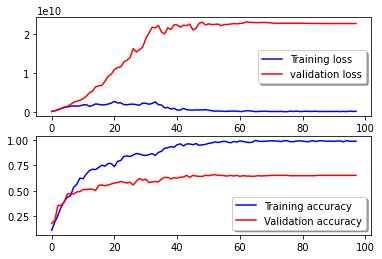

In [58]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

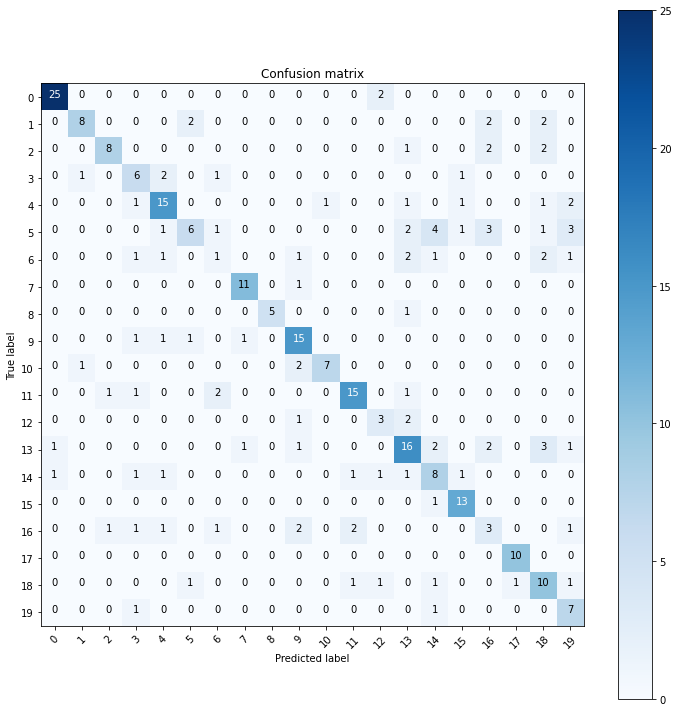

In [59]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(20))